# Load Dataset and Organize into DataFrame
organizing the image dataset into a Pandas DataFrame with image paths and corresponding labels.

In [27]:
import os
import pandas as pd

# Set the path to your dataset
dataset_path = 'gaussian_filtered_images'  # Update with your actual path

# Initialize empty lists to store image paths and labels
image_paths = []
labels = []

# Iterate over the folders in the dataset directory to get image paths and labels
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    
    if os.path.isdir(label_path):  
        for filename in os.listdir(label_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(label)  # The folder name is the label

# Create a DataFrame to hold the image paths and corresponding labels
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Show a glimpse of the data
print(df.head())


                                          image_path label
0  gaussian_filtered_images/Mild/aug_988_93be6370...  Mild
1  gaussian_filtered_images/Mild/aug_1022_abdb365...  Mild
2  gaussian_filtered_images/Mild/aug_574_7a3ea177...  Mild
3  gaussian_filtered_images/Mild/aug_169_6762b2b4...  Mild
4  gaussian_filtered_images/Mild/aug_331_d3de0d31...  Mild


# Visualize Class Distribution

Here, you're visualizing the class distribution in the dataset to check if it's imbalanced.

/tmp/ipykernel_7499/956003358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


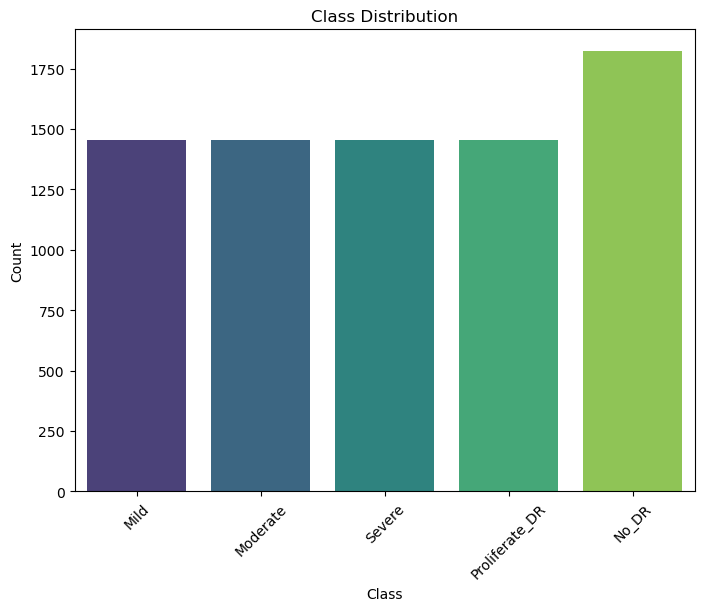

label
No_DR             1821
Mild              1456
Moderate          1456
Severe            1456
Proliferate_DR    1456
Name: count, dtype: int64


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the class distribution to see if the dataset is imbalanced
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Check the exact count of samples in each class
class_counts = df['label'].value_counts()
print(class_counts)


# Preprocess Images

This step resizes and normalizes images so they can be used in a model.

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Example: Preprocess the first image
preprocessed_image = preprocess_image(df['image_path'].iloc[0])

# Check the shape of a sample image
sample_image = load_img(df['image_path'].iloc[0])
print(f"Sample image size: {sample_image.size}")


Sample image size: (224, 224)


# Check for Image Validity

This step checks for corrupted images by trying to load each image.

In [36]:
def check_image_validity(image_paths):
    valid_images = []
    invalid_images = []
    
    for image_path in image_paths:
        try:
            img = load_img(image_path)  # Try loading the image
            valid_images.append(image_path)
        except Exception as e:
            invalid_images.append(image_path)  # If there's an error, it's invalid
            print(f"Error loading image {image_path}: {e}")
    
    return valid_images, invalid_images

# Get all image paths from your dataframe
image_paths = df['image_path'].tolist()

# Check for valid and invalid images
valid_images, invalid_images = check_image_validity(image_paths)

# Print the results
print(f"Number of valid images: {len(valid_images)}")
print(f"Number of invalid (corrupted) images: {len(invalid_images)}")

# Optionally, save the list of invalid images to a file for review
with open('invalid_images.txt', 'w') as file:
    for invalid_image in invalid_images:
        file.write(invalid_image + '\n')

# Optionally, remove the invalid images from the dataframe
df_cleaned = df[~df['image_path'].isin(invalid_images)]
print(f"Number of images after cleaning: {len(df_cleaned)}")


Number of valid images: 7645
Number of invalid (corrupted) images: 0
Number of images after cleaning: 7645


# Check for Grayscale or RGB Images
This function checks whether your images are in grayscale or RGB.

In [43]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

def check_image_channels(image_paths):
    rgb_images = []
    grayscale_images = []

    for image_path in image_paths:
        # Load the image
        img = load_img(image_path)
        
        # Convert the image to a numpy array
        img_array = np.array(img)
        
        # Check the number of channels (the last dimension of the array)
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:
            rgb_images.append(image_path)  # RGB image (3 channels)
        elif len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1):
            grayscale_images.append(image_path)  # Grayscale image (1 or 2 channels)
    
    print(f"Number of RGB images: {len(rgb_images)}")
    print(f"Number of Grayscale images: {len(grayscale_images)}")
    
    return rgb_images, grayscale_images

# Get all image paths from your dataframe
image_paths = df['image_path'].tolist()

# Check if the images are RGB or Grayscale
rgb_images, grayscale_images = check_image_channels(image_paths)


Number of RGB images: 7645
Number of Grayscale images: 0


# Detect Blurry Images
This function detects blurry images based on Laplacian Variance.

In [45]:
import cv2
from skimage.io import imread

def check_blurry_images(image_paths, threshold=100):
    blurry_images = []

    for image_path in image_paths:
        # Load the image
        img = imread(image_path)
        
        # Convert the image to grayscale (Laplacian works on single-channel)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Calculate the Laplacian variance
        laplacian_var = cv2.Laplacian(gray_img, cv2.CV_64F).var()

        # If variance is below the threshold, mark as blurry
        if laplacian_var < threshold:
            blurry_images.append(image_path)

    return blurry_images

# Get all image paths from your dataframe
image_paths = df['image_path'].tolist()

# Detect blurry images
blurry_images = check_blurry_images(image_paths)
print(f"Number of blurry images: {len(blurry_images)}")


Number of blurry images: 0


# Visualize Pixel Value Distribution
This function visualizes the distribution of pixel values for the RGB channels.

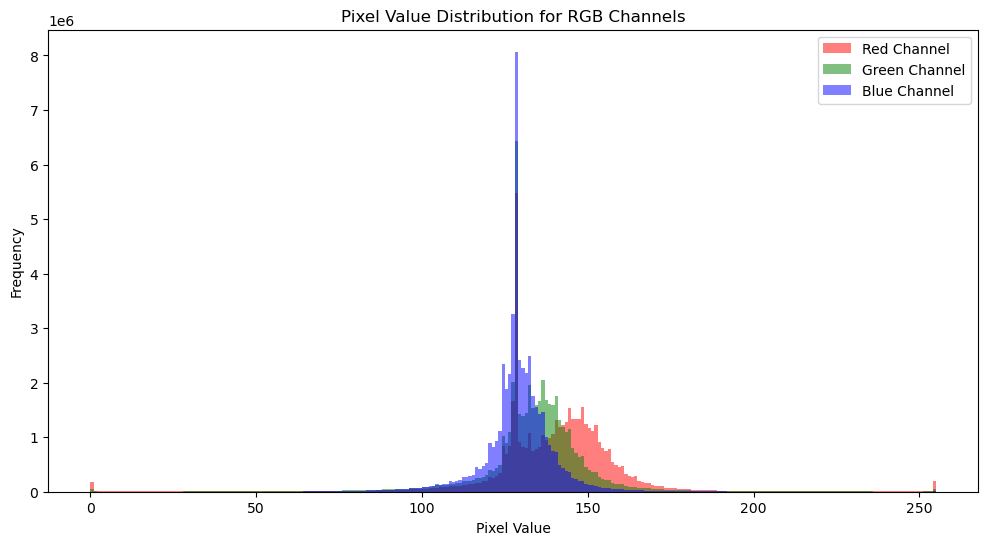

In [47]:
def plot_color_distribution(image_paths, num_images=200):
    red_channel = []
    green_channel = []
    blue_channel = []

    sampled_image_paths = np.random.choice(image_paths, size=min(num_images, len(image_paths)), replace=False)

    for image_path in sampled_image_paths:
        img = load_img(image_path, target_size=(224, 224))  # Resize
        img_array = img_to_array(img)  # Convert to array
        
        red_channel.append(img_array[:, :, 0])
        green_channel.append(img_array[:, :, 1])
        blue_channel.append(img_array[:, :, 2])

    red_channel = np.concatenate(red_channel, axis=0)
    green_channel = np.concatenate(green_channel, axis=0)
    blue_channel = np.concatenate(blue_channel, axis=0)

    plt.figure(figsize=(12, 6))
    plt.hist(red_channel.ravel(), bins=255, color='red', alpha=0.5, label='Red Channel')
    plt.hist(green_channel.ravel(), bins=255, color='green', alpha=0.5, label='Green Channel')
    plt.hist(blue_channel.ravel(), bins=255, color='blue', alpha=0.5, label='Blue Channel')
    plt.title('Pixel Value Distribution for RGB Channels')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

# Call the function to plot the color distribution for a subset of images
plot_color_distribution(df['image_path'], num_images=1000)


# Data Augmentation
Here, the code for real-time data augmentation is provided.

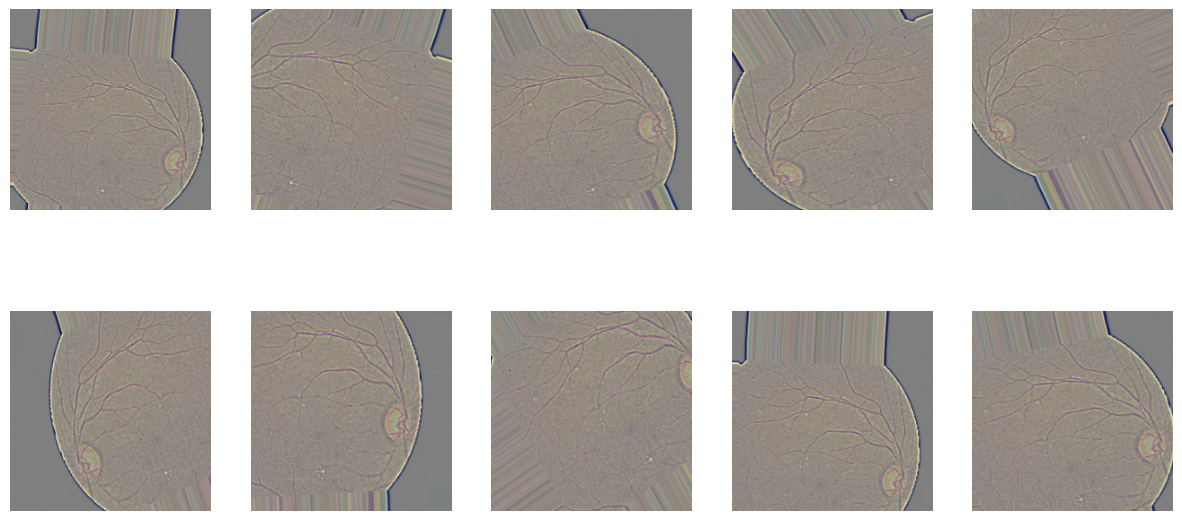

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=40,          # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,      # Random width shift (20% of total width)
    height_shift_range=0.2,     # Random height shift (20% of total height)
    shear_range=0.2,            # Random shear transformations
    zoom_range=0.2,             # Random zoom transformations
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill the missing pixels after transformation
)

# Function to visualize the augmented images
def visualize_augmented_images(image_path, num_images=10):
    # Load a sample image
    img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224
    img_array = img_to_array(img)  # Convert the image to numpy array
    img_array = img_array.reshape((1, ) + img_array.shape)  # Reshape for the generator

    # Generate augmented images
    i = 0
    plt.figure(figsize=(15, 15))
    
    for batch in datagen.flow(img_array, batch_size=1,  save_prefix='aug', save_format='jpeg'):
        plt.subplot(4, 5, i + 1)  # Display 10 images (adjust as per your requirement)
        plt.imshow(batch[0])
        plt.axis('off')
        i += 1
        if i >= num_images:  # Stop after 'num_images' augmented images
            break
    
    plt.show()

# Visualize 10 augmented images for a sample image from your dataset
visualize_augmented_images(df['image_path'].iloc[0], num_images=10)  # Update with your image path


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# 1. Set Device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Data Transformation with Data Augmentation
transform = transforms.Compose([
    transforms.RandomRotation(40),               # Random rotation between 0 and 40 degrees
    transforms.RandomHorizontalFlip(),            # Flip images horizontally
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Random shift in width and height
    transforms.Resize((224, 224)),                # Resize to the target size
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# 3. Dataset and DataLoader
dataset = datasets.ImageFolder(root="./gaussian_filtered_images", transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names and number of classes
class_names = dataset.classes
num_classes = len(class_names)

# 4. Vision Transformer (ViT) Model Setup
model = models.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# 5. MixUp Data Augmentation (for training)
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 6. Training Loop with Augmentation
num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (lam * preds.eq(targets_a).sum().item() +
                          (1 - lam) * preds.eq(targets_b).sum().item())
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train

    # 7. Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_acc = 100 * correct_val / total_val

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {avg_val_loss:.4f}, "
          f"Val Acc = {val_acc:.2f}%")

# 8. Final Evaluation
acc = accuracy_score(y_true, y_pred) * 100
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
conf_mat = confusion_matrix(y_true, y_pred)

print(f"\n✅ Final Accuracy: {acc:.2f}%")
print("\n📄 Classification Report:\n", report)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ViT - Confusion Matrix")
plt.tight_layout()
plt.show()


Using device: cpu


/home/ali-raza-tareen/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ali-raza-tareen/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/ali-raza-tareen/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [01:11<00:00, 4.85MB/s] 
Epoch 1/30:   0%|          | 0/192 [00:00<?, ?it/s]